# Machine Learning Methods for Empirical Dynamic Modeling

_Kevin Siswandi | July 2020_

We demonstrate a few approaches for empirical dynamic modeling with machine learning tools:
* One-step Learning
* LmmNet
* Recurrent Neural Network (maybe)

Here we will demonstrate it on the canonical 3-D Linear Oscillator. Later, we will try to see how it performs with noisy data. Finally, we see how the method can extract insights from what it has learnt from data.

In [1]:
import sys
sys.path.append("./source")

# libraries for this project
from lmmNet import *
import linear
import train_onestep
import predict_onestep
import predict_lmmNet

import numpy as np
from scipy.integrate import odeint
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d

The dynamics of the test problem considered here is given by the linear ODE:

<img src=image/linear-equation.png alt="drawing" align ="centre" width="300"/>   
with the initial condition $(x_0, y_0, z_0) = (2,0,1)$.

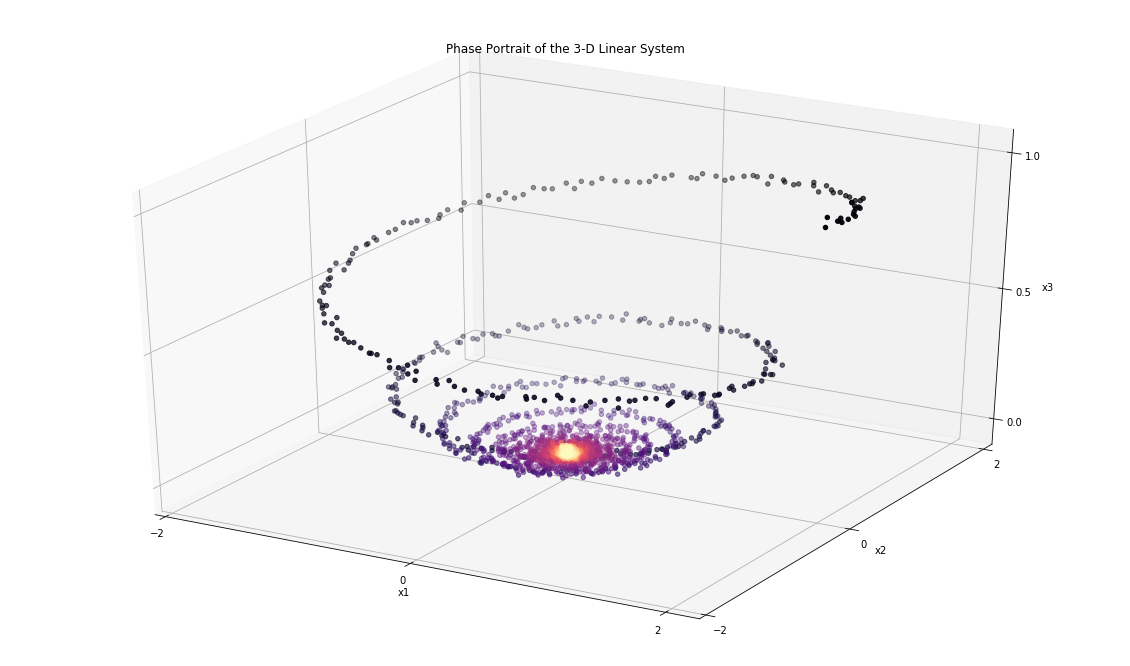

In [2]:
time_points, linear_data = linear.simulate_custom(noise=0.05, step=0.02)

# Phase portrait
fig = plt.figure(figsize=(20, 12))
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='magma')
#ax.grid(False)
ax.set_title('Phase Portrait of the 3-D Linear System')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

## 1. LmmNet

Training is done to find the optimal parameters via minimising loss function:

$$ \arg \min_w \frac{1}{N - M + 1} \sum_{n = M}^{N} |\textbf{y}_n|^2 $$

where N is the number of data points and M multi steps. The linear difference/residual operator is defined as

$$ \textbf{y}_n = \sum_{n=0}^M \left(\alpha_m x_{n-m} + h \beta_m \textbf{f}(\textbf{x}_{n-m}) \right)$$

for $n=M,...,N$.

In [3]:
# we specify a LMM scheme and number of steps
dt = time_points[1] - time_points[0]
M = 1
scheme = 'AM'
model = lmmNet(dt, linear_data, M, scheme, hidden_units=256)

N_Iter = 10000
model.train(N_Iter, debug=False)

In [4]:
x0 = linear_data[0,0,:] # initial conditions
predicted_traj = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), x0, time_points)

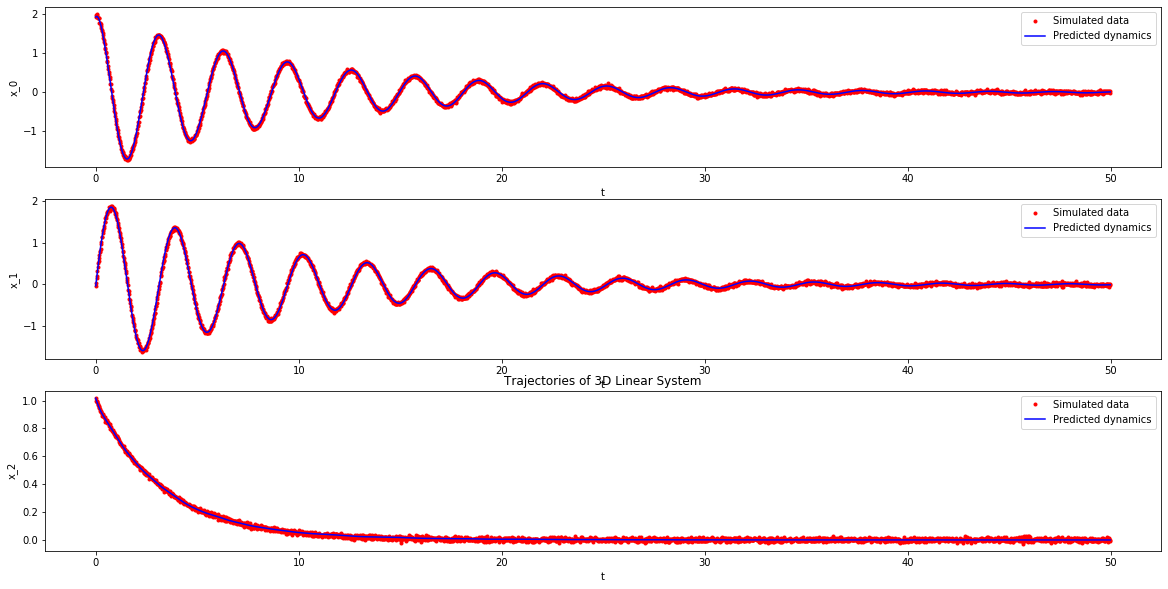

In [5]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(3):
    plt.subplot(3,1,species + 1)
    plt.plot(time_points, linear_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 3D Linear System')
plt.show()

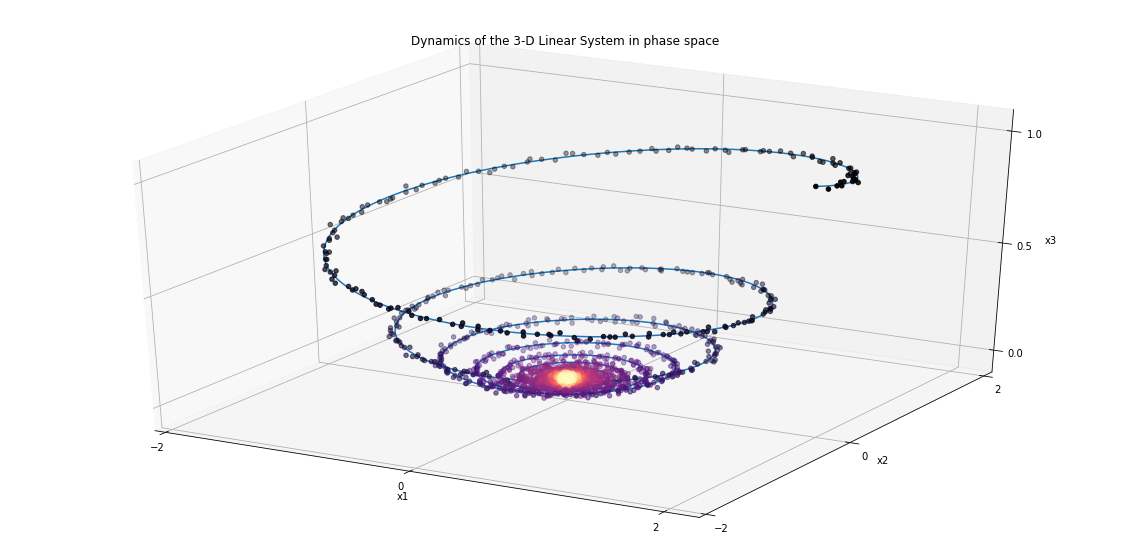

In [6]:
# Phase portrait
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(linear_data[0,:,0], linear_data[0,:,1], linear_data[0,:,2], c=time_points, cmap='magma')
ax.plot3D(predicted_traj[:,0], predicted_traj[:,1], predicted_traj[:,2])
#ax.grid(False)
ax.set_title('Dynamics of the 3-D Linear System in phase space')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

In [9]:
# now we try it on a test data
print("The time step is: ", dt)
time_points, test_data = linear.simulate_custom(xinit=3, yinit=4, zinit=2, step=dt)
predicted_test = odeint(lambda x, t: predict_lmmNet.predict_fn(x, t, model), test_data[0,0,:], time_points)

The time step is:  0.02


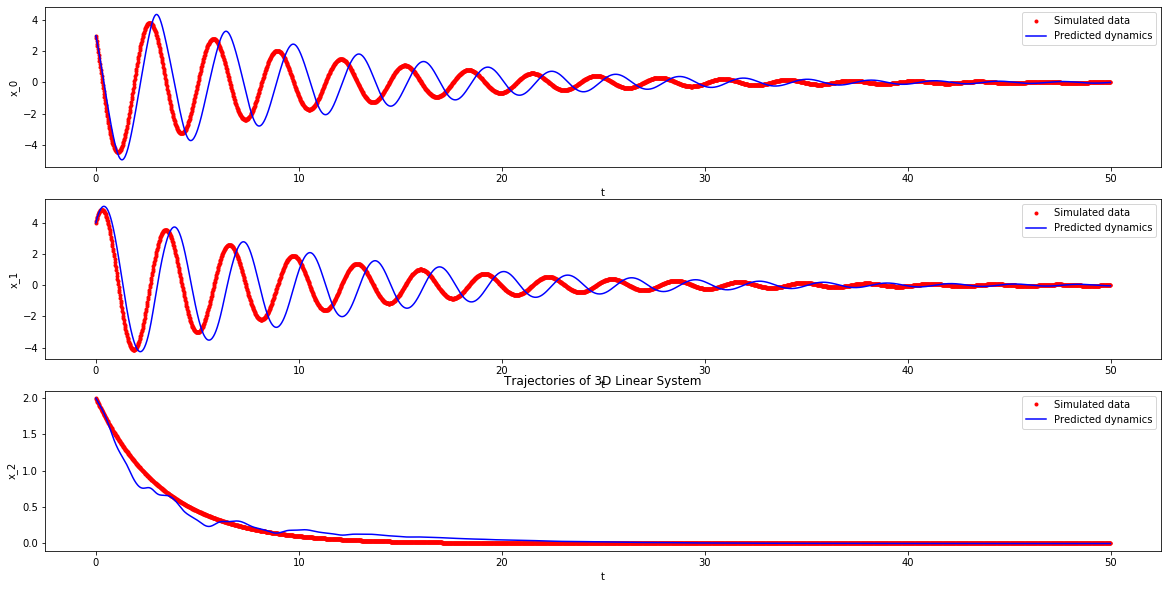

In [10]:
# plot the time-course of the predicted trajectory

plt.figure(figsize=(20, 10))

for species in range(3):
    plt.subplot(3,1,species + 1)
    plt.plot(time_points, test_data[0,:, species], 'r.', label='Simulated data')
    plt.plot(time_points, predicted_test[:,species], 'b-', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('x_' + str(species))
    plt.legend()
    
plt.title('Trajectories of 3D Linear System')
plt.show()

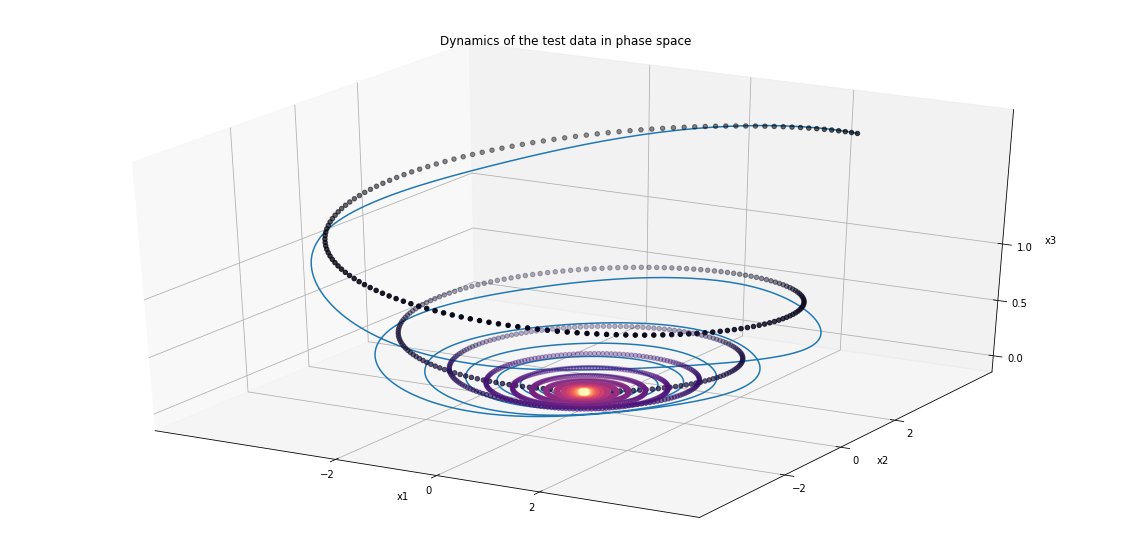

In [11]:
# Phase portrait
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(test_data[0,:,0], test_data[0,:,1], test_data[0,:,2], c=time_points, cmap='magma')
ax.plot3D(predicted_test[:,0], predicted_test[:,1], predicted_test[:,2])
#ax.grid(False)
ax.set_title('Dynamics of the test data in phase space')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")
ax.set_xticks([-2,0, 2 ])
ax.set_yticks([-2,0, 2 ])
ax.set_zticks([0, 0.5, 1])
plt.show()

## 2. One-step Learning

Notes:
* The test data is generated noise-free
* Data are (0, 50) with step 0.02, so total 2500 points

In [3]:
from utils import *

feature_list = []
target_list = ['x_component', 'y_component', 'z_component']
df = create_data(linear_data, time_points, cols=target_list)
print("Shape of the tensor is: ", linear_data.shape)

Shape of the dataframe is: (2500, 4)
Shape of the tensor is:  (1, 2500, 3)


In [4]:
# create training data with different augmentation

df_train = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=2500)
df_train2 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=5000)
df_train3 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=10000)
df_train4 = train_onestep.generate_dataset(df, [0],feature_list, target_list, n_dim=20000)

x_component


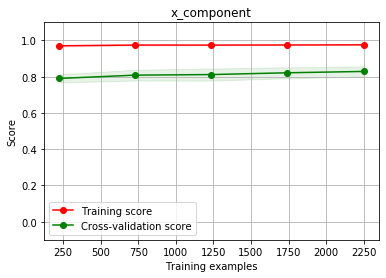

Target: x_component, CV Pearson R2 coefficient: 0.975077
y_component


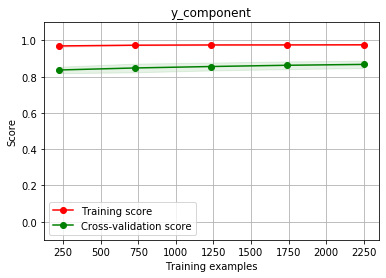

Target: y_component, CV Pearson R2 coefficient: 0.976203
z_component


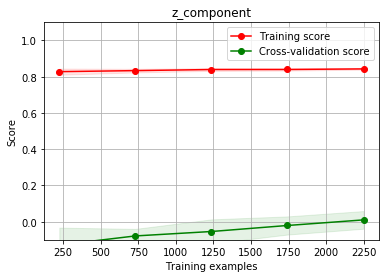

Target: z_component, CV Pearson R2 coefficient: 0.842248
Average training score: 0.9311757348332307
x_component RMSE: -0.0006209407020057508 standard deviation: 0.1530018955555215


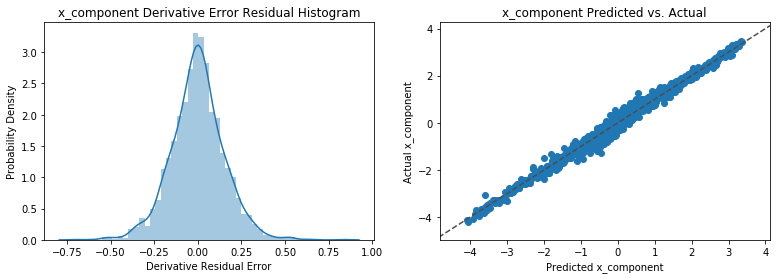

y_component RMSE: -0.0036461914703680015 standard deviation: 0.14896784564574592


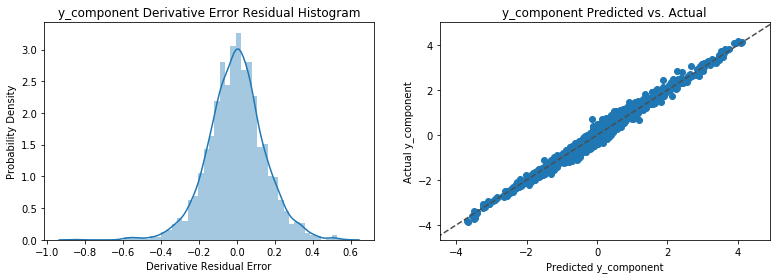

z_component RMSE: 0.0015867208627331718 standard deviation: 0.05785305574504511


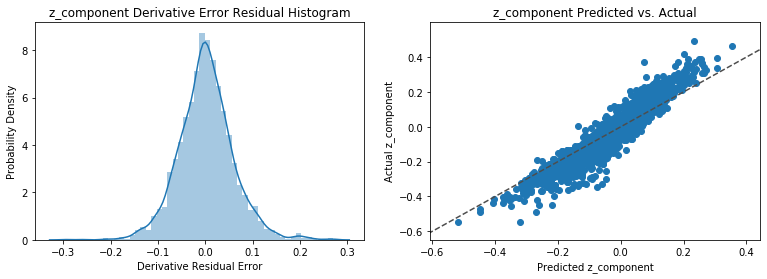

Total Derivative Mean Error: 0.5750346185047949 Error Standard Deviation: 0.12447775707154687


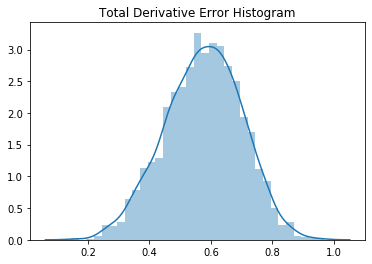

Real data:


,x_component,y_component,z_component
Strain,,,
0,1.985090,-0.014763,0.990254
0,1.940895,0.088319,1.008717
0,1.961278,0.198720,0.982635
0,1.985679,0.211452,0.978303
0,1.980375,0.310010,0.976083
...,...,...,...
0,-0.004566,-0.022790,-0.003209
0,-0.020738,-0.018039,-0.011413
0,-0.015420,-0.042771,0.001499


Predicted data:


,x_component,y_component,z_component
Time,,,
0.00,1.985090,-0.014763,0.990254
0.02,1.981240,0.063307,0.984214
0.04,1.978030,0.138680,0.978288
0.06,1.976158,0.212718,0.972514
0.08,1.967732,0.287429,0.967230
...,...,...,...
49.90,-0.053242,0.028165,0.011894
49.92,-0.052710,0.028381,0.011991
49.94,-0.052826,0.028572,0.012005


./source/predict_onestep.py:217: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rmse = math.sqrt(quad(integrand,min(times),max(times),limit=200)[0])
./source/predict_onestep.py:222: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  

ML Fit: x_component 1.0721715018152633 RMSE percentage: 295.41101285280394
ML Fit: y_component 1.02612972265807 RMSE percentage: 297.8319510638563
ML Fit: z_component 0.07244485744323058 RMSE percentage: 140.09151201786918
ML model aggregate error
Average RMSE: 0.7235820273055213
Total percentage error: 244.44482531150982


ValueError: num must be 1 <= num <= 2, not 3

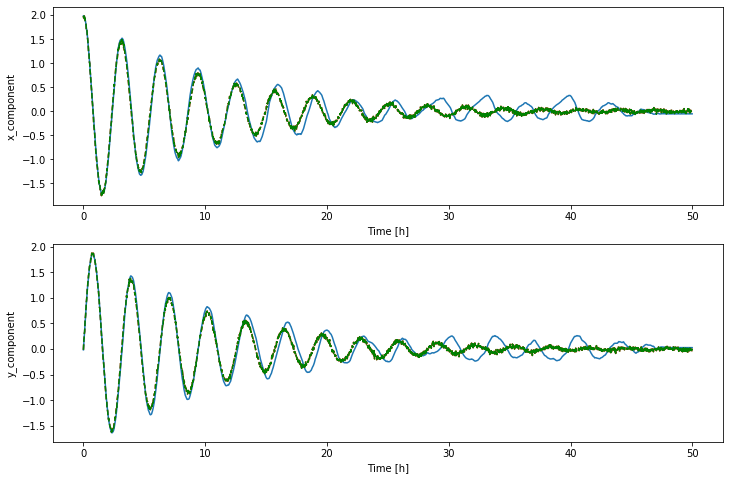

In [5]:
tp1, pred1 = end_to_end_training(df, df_train, df, feature_list, target_list, (3,1))
tp2, pred2 = end_to_end_training(df, df_train2, df, feature_list, target_list, (3,1))
tp3, pred3 = end_to_end_training(df, df_train3, df, feature_list, target_list, (3,1))
tp4, pred4 = end_to_end_training(df, df_train4, df, feature_list, target_list, (3,1))

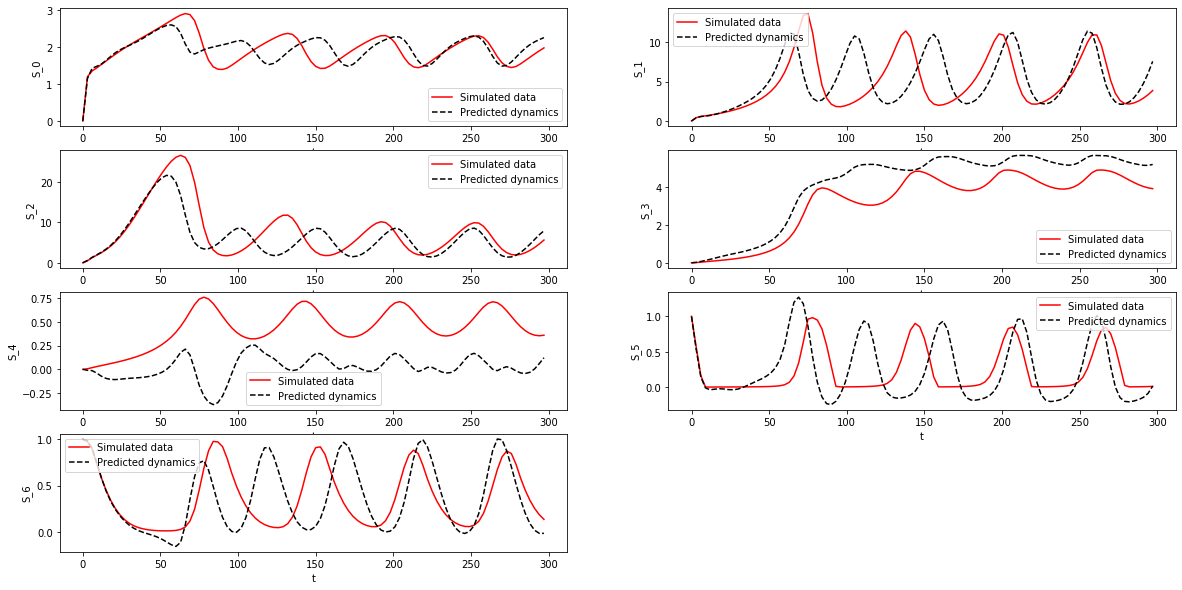

In [10]:
# plot and compare the predicted and true dynamics

plt.figure(figsize=(20, 10))
plt.title('Trajectories of Cell Cycle Model')

for species in range(7):
    plt.subplot(4,2,species + 1)
    plt.plot(time_points, data_array[0, :, species], 'r-', label='Simulated data')
    plt.plot(time_points, predicted_traj[:,species], 'k--', label='Predicted dynamics')
    plt.xlabel('t')
    plt.ylabel('S_' + str(species))
    plt.legend()
    
plt.show()

In [2]:
# train the model
time_points, data_array = simulate_custom(step_size=2.5)

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet_beta(step_size, data_array, M = 1, scheme='AM', hidden_units=256, loss_type='Wasserstein') # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs, debug=False)

# Solve the initial value problem given initial concentrations
predicted_traj = odeint(lambda x, t: predict_fn(x, t, net), data_array[0, 0,:], time_points)

ValueError: No gradients provided for any variable: ['dense_model/dense/kernel:0', 'dense_model/dense/bias:0', 'dense_model/dense_1/kernel:0', 'dense_model/dense_1/bias:0'].

RMSE: $||x_i - y_i||^2$

Wasserstein: minimum way to assign each $x_i$ to each $y_i$. This asssignment is equivalent to an optimal transport problem.